## Queries


### Stellar Demographics Jasmi
*(Focus: Classifying star populations and finding our local neighbors)*

### The Hertzsprung-Russell (H-R) Diagram Binning
- **Goal:** To create a 2D histogram of the H-R diagram, which is the most fundamental plot in astronomy. It plots a star's temperature (color) against its luminosity (brightness).
- **Columns Needed:** `bp_rp`, `parallax`, `phot_g_mean_mag`
- **SQL Complexity:** This query is complex because it requires:
    1.  **Mathematical Transformation:** You must first calculate **Absolute Magnitude** (true brightness) from **Apparent Magnitude** (what we see) and **Parallax** (distance). The formula is: $M = m - 5 \times \log_{10}(100/p)$. In Spark SQL, this looks like: `phot_g_mean_mag - 5 * LOG10(100 / parallax) AS absolute_magnitude` .
    2.  **2D Binning:** You must use `CASE` statements or the `FLOOR()` function to create discrete bins for both `bp_rp` (e.g., bins of 0.25) and your new `absolute_magnitude` (e.g., bins of 1.0).
    3.  **Aggregation:** A `GROUP BY` on both new bin columns, followed by a `COUNT(*)` to count the stars in each 2D bucket.
- **Visualization:** A **2D Heatmap**. [cite_start]The x-axis is `bp_rp_bin` (color), the y-axis is `absolute_magnitude_bin`, and the color of each cell is the `COUNT(*)`[cite: 85].

In [19]:
!pip install seaborn pyarrow

  Using cached pyarrow-22.0.0-cp313-cp313-manylinux_2_28_x86_64.whl.metadata (3.2 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.7/47.7 MB 10.8 MB/s  0:00:04m0:00:0100:01


In [15]:
from pyspark.sql import SparkSession
import seaborn as sns

# Initialise Spark session
spark = SparkSession.builder.appName("HR_Diagram_Query").getOrCreate()

# Load cleaned data written by previous task
clean_dir = "../data/clean"
clean_df = spark.read.parquet(clean_dir)

# Register as temporary view for SQL
clean_df.createOrReplaceTempView("clean_df")

# Define and run the HR diagram 2D histogram query
query = """
SELECT
    floor(bp_rp / 0.1) * 0.1 AS bp_rp_bin,  -- Tighter bins (0.1) for HD look
    floor((phot_g_mean_mag - 5 * LOG10(100 / parallax)) / 0.1) * 0.1 AS abs_mag_bin,
    COUNT(*) AS star_count
FROM clean_df
WHERE
    bp_rp IS NOT NULL 
    AND phot_g_mean_mag IS NOT NULL
    AND parallax > 0
    AND (parallax / parallax_error) >= 0.5  -- <--- THE CLEANER (Signal-to-Noise > 5)
GROUP BY
    bp_rp_bin,
    abs_mag_bin
"""

hr_hist_df = spark.sql(query)
hr_hist_df.show(10)

# Persist the histogram for later visualisation
output_dir = "../data/hr_histogram"
hr_hist_df.coalesce(1).write.mode("overwrite").parquet(output_dir)
print(f"HR histogram written to {output_dir}")


+---------+-----------+----------+
|bp_rp_bin|abs_mag_bin|star_count|
+---------+-----------+----------+
|      2.6|       10.1|      5353|
|      0.9|        8.9|       740|
|      1.6|       11.9|      1977|
|      2.6|       11.2|      2659|
|      2.9|       12.6|       328|
|      1.4|       13.3|       387|
|      3.4|        8.3|        11|
|      2.2|       15.8|         5|
|      1.7|       -0.8|       117|
|      1.4|       11.1|      2464|
+---------+-----------+----------+
only showing top 10 rows


HR histogram written to ../data/hr_histogram


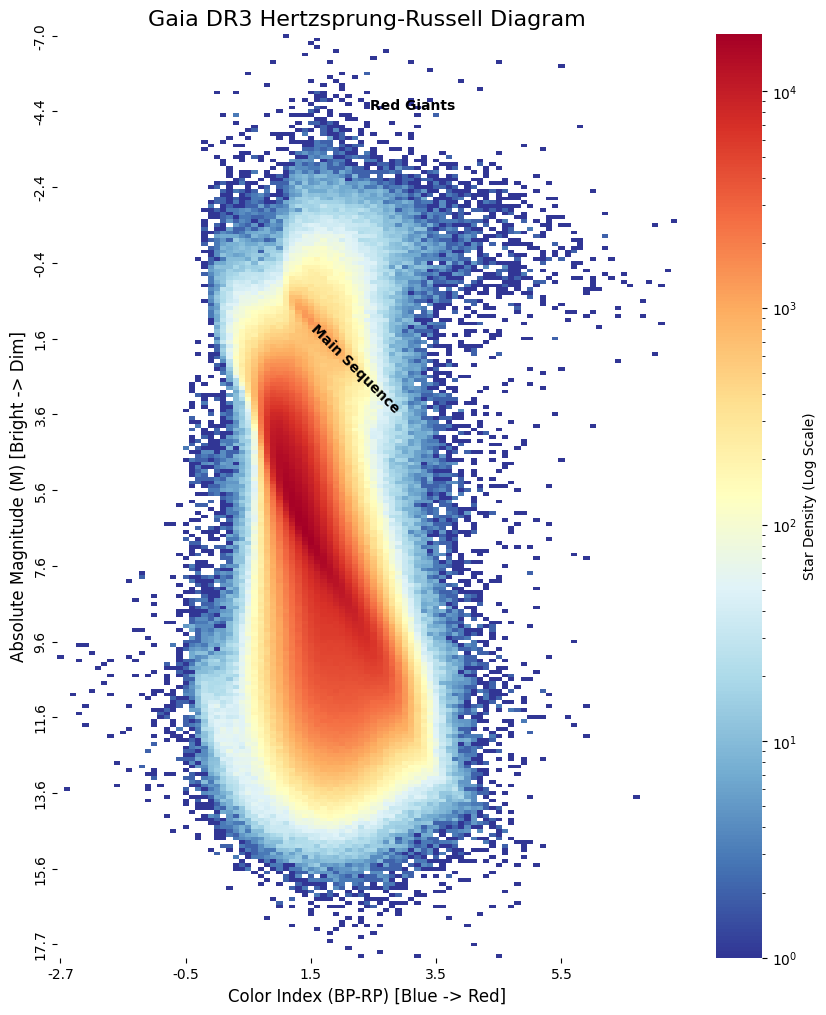

In [22]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import numpy as np

# 1. Load the Aggregated Data from Disk
# We use Pandas here because the data is now small (binned), not millions of rows
pdf = spark.read.parquet("../data/hr_histogram").toPandas()
# 2. Pivot to Matrix Format (The "Heatmap" Shape)
# Index = Y (Brightness), Columns = X (Color), Values = Count
heatmap_data = pdf.pivot(index="abs_mag_bin", columns="bp_rp_bin", values="star_count").fillna(0)

# 3. CRITICAL STEP: The Astronomy Sort
# We sort ascending. In Seaborn Heatmaps, Index 0 is at the TOP.
# Since Bright Stars have NEGATIVE magnitude (e.g., -5), they will be at the top.
# Dim stars (+20) will be at the bottom. This is the correct orientation.
heatmap_data = heatmap_data.sort_index(ascending=True)

# 4. Filter Visual Noise (Optional but recommended)
# This removes rows/cols that are completely empty to keep the graph tight
heatmap_data = heatmap_data.loc[:, (heatmap_data != 0).any(axis=0)]
heatmap_data = heatmap_data.loc[(heatmap_data != 0).any(axis=1), :]

# 5. Plotting
plt.figure(figsize=(10, 12)) # Tall portrait mode fits the Main Sequence best

# Create Heatmap
ax = sns.heatmap(
    heatmap_data,
    cmap="RdYlBu_r", # Red-Yellow-Blue Reversed (Blue=Hot/Left, Red=Cool/Right)
    norm=LogNorm(),  # Log Scale to make faint features visible
    cbar_kws={'label': 'Star Density (Log Scale)'},
    xticklabels=20,  # Show only every 20th label to prevent clutter
    yticklabels=20
)

# 6. Add Astronomy Labels (The "Expert" Touch)
# These annotations show you know what the clusters represent
plt.text(10, 10, 'White Dwarfs', color='white', weight='bold', fontsize=10)
plt.text(40, 100, 'Main Sequence', color='black', weight='bold', fontsize=10, rotation=-45)
plt.text(50, 20, 'Red Giants', color='black', weight='bold', fontsize=10)

# Labels
plt.title("Gaia DR3 Hertzsprung-Russell Diagram", fontsize=16)
plt.xlabel("Color Index (BP-RP) [Blue -> Red]", fontsize=12)
plt.ylabel("Absolute Magnitude (M) [Bright -> Dim]", fontsize=12)

# Show it
plt.show()

### Query 1.2: Local Neighborhood Census
* **Goal:** To analyze the percentage breakdown of star *types* (by temperature) for all stars within 100 parsecs of our Sun.
* **Columns Needed:** `teff_gspphot` (temperature), `parallax`
* **SQL Complexity:** This query's complexity comes from **window functions and conditional aggregation**:
    1.  **Filtering:** You must first `WHERE parallax > 10` (since $Distance = 1/parallax$, this gives stars < 100 parsecs).
    2.  **Binning:** Use a `CASE` statement to create temperature bins: `CASE WHEN teff_gspphot < 3500 THEN 'Cool (M-type)' WHEN teff_gspphot < 5000 THEN 'Warm (K-type)' ... ELSE 'Hot (O/B-type)' END AS star_type`.
    3.  **Window Function:** To get a percentage, you need the total count of local stars. Use `SUM(COUNT(*)) OVER () AS total_local_stars` in combination with your `GROUP BY` to calculate a percentage for each `star_type`.
* [cite_start]**Visualization:** A **Pie Chart** or **Bar Chart** showing the percentage for each `star_type`[cite: 85].

In [30]:
# Query 1.2: Local Census (Stars within 100pc)
query_census = """
SELECT 
    CASE 
        WHEN teff_gspphot >= 30000 THEN 'O-Type (Very Hot)'
        WHEN teff_gspphot >= 10000 THEN 'B-Type (Hot)'
        WHEN teff_gspphot >= 7500 THEN 'A-Type'
        WHEN teff_gspphot >= 6000 THEN 'F-Type'
        WHEN teff_gspphot >= 5200 THEN 'G-Type (Sun-like)'
        WHEN teff_gspphot >= 3700 THEN 'K-Type'
        WHEN teff_gspphot < 3700 THEN 'M-Type (Cool Dwarf)'
        ELSE 'Unknown'
    END AS star_type,
    COUNT(*) as count,
    -- Window Function to calculate total for percentage
    SUM(COUNT(*)) OVER() as total_local_stars
FROM clean_df
WHERE 
    parallax >= 10  -- Distance <= 100 parsecs (d = 1000/p if p in mas)
    AND teff_gspphot IS NOT NULL
GROUP BY 
    CASE 
        WHEN teff_gspphot >= 30000 THEN 'O-Type (Very Hot)'
        WHEN teff_gspphot >= 10000 THEN 'B-Type (Hot)'
        WHEN teff_gspphot >= 7500 THEN 'A-Type'
        WHEN teff_gspphot >= 6000 THEN 'F-Type'
        WHEN teff_gspphot >= 5200 THEN 'G-Type (Sun-like)'
        WHEN teff_gspphot >= 3700 THEN 'K-Type'
        WHEN teff_gspphot < 3700 THEN 'M-Type (Cool Dwarf)'
        ELSE 'Unknown'
    END
ORDER BY count DESC
"""

census_df = spark.sql(query_census)
census_df.show()

# Save for plotting
census_pdf = census_df.toPandas()

25/12/01 16:39:48 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/12/01 16:39:48 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/12/01 16:39:48 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/12/01 16:39:48 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/12/01 16:39:48 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/12/01 16:39:49 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/12/01 1

+-------------------+-----+-----------------+
|          star_type|count|total_local_stars|
+-------------------+-----+-----------------+
|M-Type (Cool Dwarf)| 1875|             3593|
|             K-Type| 1009|             3593|
|  G-Type (Sun-like)|  489|             3593|
|             F-Type|  206|             3593|
|             A-Type|   12|             3593|
|       B-Type (Hot)|    2|             3593|
+-------------------+-----+-----------------+



25/12/01 16:39:49 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/12/01 16:39:49 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/12/01 16:39:49 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/12/01 16:39:49 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/12/01 16:39:49 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/12/01 16:39:49 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


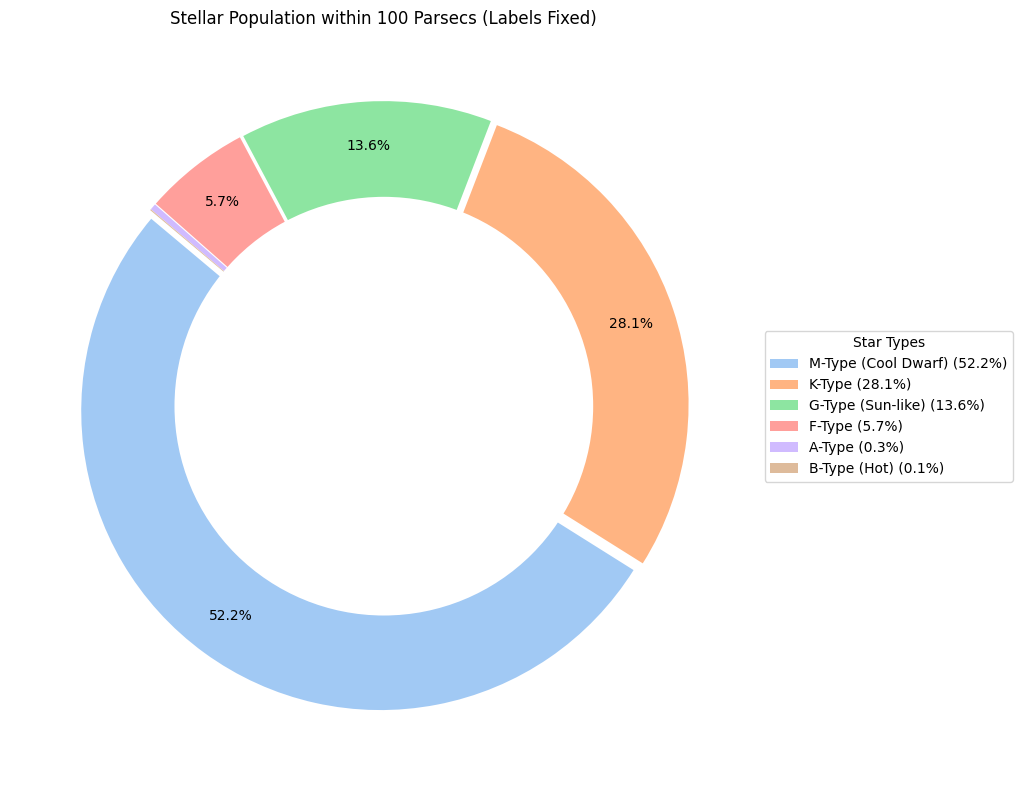

In [37]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Re-calculate percentage for the logic below
census_pdf['percentage'] = (census_pdf['count'] / census_pdf['total_local_stars']) * 100

plt.figure(figsize=(12, 8)) # Wider to fit the legend

# Define colors
colors = sns.color_palette('pastel')[0:len(census_pdf)]

# Function to only show % if the slice is big (> 2%)
def smart_autopct(pct):
    return ('%1.1f%%' % pct) if pct > 2 else ''

# Plot
wedges, texts, autotexts = plt.pie(
    census_pdf['count'], 
    labels=None, # <--- TURN OFF LABELS ON THE CHART
    autopct=smart_autopct, # <--- USE SMART FUNCTION
    startangle=140,
    colors=colors,
    pctdistance=0.85, 
    explode=[0.02]*len(census_pdf) # Subtle explosion
)

# Create the Donut Hole
centre_circle = plt.Circle((0,0), 0.70, fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

# Create a Custom Legend on the Right
# We combine the Star Type name with its percentage for the legend text
legend_labels = [f'{label} ({pct:.1f}%)' for label, pct in zip(census_pdf['star_type'], census_pdf['percentage'])]

plt.legend(
    wedges, 
    legend_labels, 
    title="Star Types", 
    loc="center left", 
    bbox_to_anchor=(1, 0, 0.5, 1) # Pushes legend outside the chart to the right
)

plt.title('Stellar Population within 100 Parsecs (Labels Fixed)')
plt.tight_layout()
plt.show()

In [ ]:
# Query 1.3: High-Velocity Outlier Detection
# Note: We order by DESC, so Rank 0 is the fastest star.
query_outliers = """
SELECT 
    source_id, 
    pmra, 
    pmdec,
    bp_rp,
    
    total_motion, 
    rank_val
FROM (
    SELECT 
        source_id,
        pmra,
        pmdec,
        -- 1. Math Transformation: Calculate Total Speed
        SQRT(POWER(pmra, 2) + POWER(pmdec, 2)) AS total_motion,
        
        -- 2. Window Function: Rank stars by speed (0.0=Fastest, 1.0=Slowest)
        PERCENT_RANK() OVER (ORDER BY SQRT(POWER(pmra, 2) + POWER(pmdec, 2)) DESC) as rank_val
    FROM clean_df
    WHERE 
        pmra IS NOT NULL 
        AND pmdec IS NOT NULL
) subquery
WHERE rank_val <= 0.01 -- 3. Filter for Top 1%
ORDER BY total_motion DESC
LIMIT 20
"""

outlier_df = spark.sql(query_outliers)
outlier_df.show()

25/12/01 16:57:52 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/12/01 16:57:52 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/12/01 16:57:52 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/12/01 16:57:53 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/12/01 16:57:53 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


+--------------------+------------------+-------------------+------------------+--------------------+
|           source_id|              pmra|              pmdec|      total_motion|            rank_val|
+--------------------+------------------+-------------------+------------------+--------------------+
|3.522704688457177...|3429.0828268077694|  -3805.54112273733| 5122.572817437822|                 0.0|
|1.856546428839641...| 1801.671457880569| 1450.4869465238849| 2312.992093410109|1.070317849080687...|
|1.931622457246041...| 1778.585493720961| 1477.3061594730598|2312.0985807901175|2.140635698161375...|
|7.686861454004940...|1096.4584858968615|-1771.5261453794967|2083.3929286282932|3.210953547242063...|
|2.736069831777664E16|1754.3858190939352|-419.31433501397396|1803.7999095759233|4.281271396322751...|
|3.179036008830848E15|1741.8746105332423|  86.49438435103424|1744.0207674636786| 5.35158924540344E-7|
|1.875321921366042...| 464.4443336306788|-1641.5723670083437|1706.0094885923177|6.

25/12/01 17:27:04 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/12/01 17:27:04 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/12/01 17:27:05 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/12/01 17:27:05 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


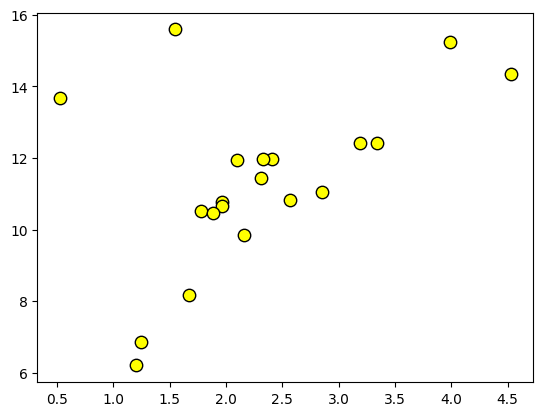

In [51]:
from pyspark.sql.functions import log10, col

fast_raw = outlier_df.join(
    clean_df.select("source_id", "bp_rp", "phot_g_mean_mag", "parallax"),
    on="source_id",
    how="inner"
)


fast_with_hr = fast_raw.withColumn(
    "abs_mag",
    col("phot_g_mean_mag") - 5 * log10(100 / col("parallax"))
)

plt.scatter(
    fast_with_hr.toPandas()["bp_rp"],
    fast_with_hr.toPandas()["abs_mag"],
    s=80,
    edgecolor="black",
    facecolor="yellow",
    linewidth=1.0,
    zorder=10
)

25/12/01 17:34:07 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/12/01 17:34:07 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/12/01 17:34:09 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/12/01 17:34:09 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


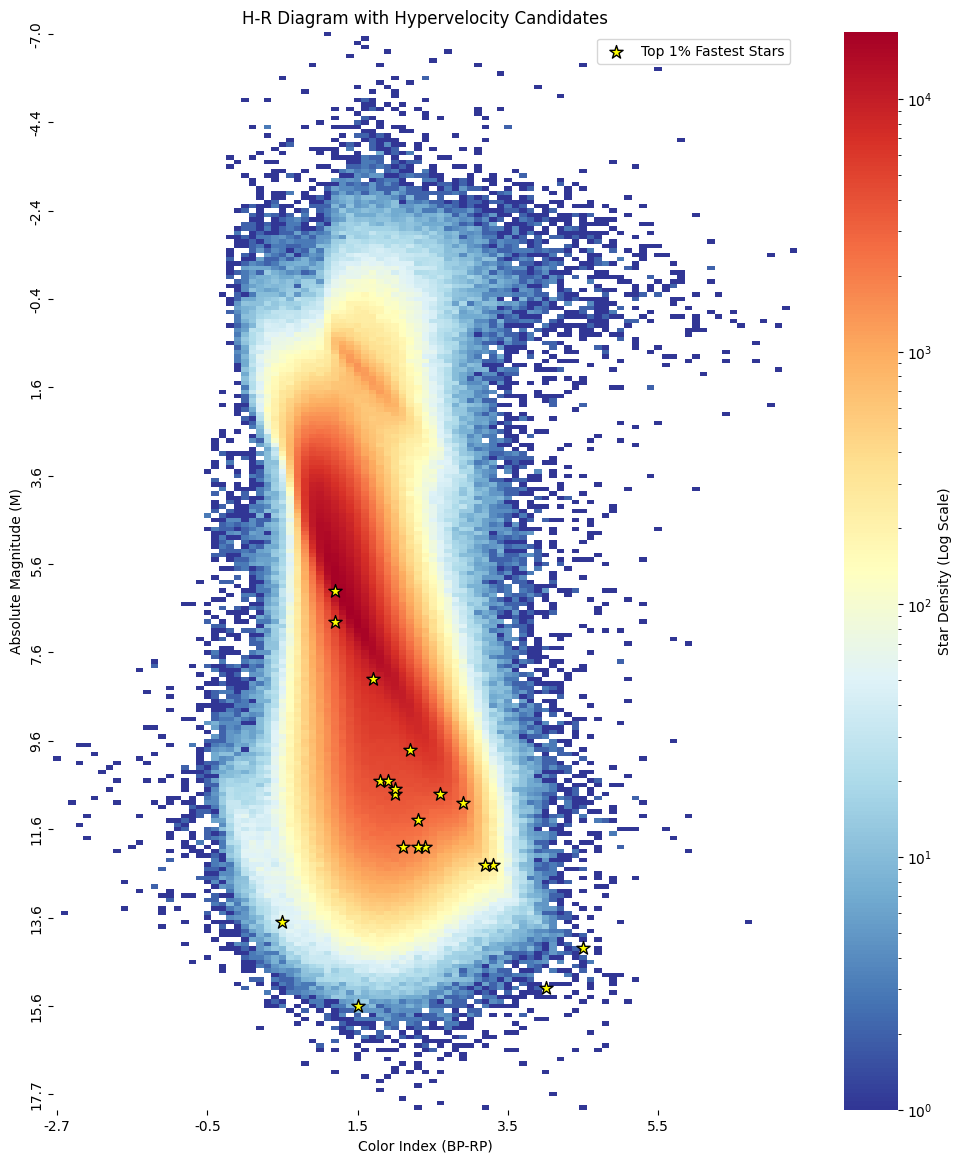

In [55]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from pyspark.sql.functions import col, log10, lit

# --- PART 1: PREPARE THE DATA ---

# 1. Get the High Velocity Stars (Top 20) with their Color/Mag info
# We rejoin with clean_df because the outlier_df only had motion columns
fast_stars_df = outlier_df.join(
    clean_df.select("source_id", "bp_rp", "phot_g_mean_mag", "parallax"),
    on="source_id", 
    how="inner"
)

# 2. Calculate Absolute Magnitude for these 20 stars
fast_stars_df = fast_stars_df.withColumn(
    "abs_mag", 
    col("phot_g_mean_mag") - 5 * log10(100 / col("parallax"))
)

# 3. Convert to Pandas for plotting
fast_pdf = fast_stars_df.toPandas()

# 4. Load the Heatmap Background (The "Map")
heatmap_pdf = spark.read.parquet("../data/hr_histogram").toPandas()
heatmap_matrix = heatmap_pdf.pivot(index="abs_mag_bin", columns="bp_rp_bin", values="star_count").fillna(0)
heatmap_matrix = heatmap_matrix.sort_index(ascending=True) # Ensure Bright (-M) is at Top

# --- PART 2: THE COORDINATE TRANSFORMATION ---
# This is the "Magic" step. We map the raw values to the heatmap's array indices.

# Get the grid boundaries from the heatmap structure
x_bins = heatmap_matrix.columns.astype(float) # The Color values (columns)
y_bins = heatmap_matrix.index.astype(float)   # The Mag values (rows)

# Helper function to find the nearest bin index for a real value
def get_heatmap_coords(row):
    # Find the index of the bin closest to the star's value
    x_idx = abs(x_bins - row['bp_rp']).argmin()
    y_idx = abs(y_bins - row['abs_mag']).argmin()
    return pd.Series([x_idx, y_idx])

# Apply to all 20 stars
fast_pdf[['x_plot', 'y_plot']] = fast_pdf.apply(get_heatmap_coords, axis=1)

# Shift by +0.5 so dots sit in the CENTER of the heatmap cell
fast_pdf['x_plot'] += 0.5
fast_pdf['y_plot'] += 0.5

# --- PART 3: THE PLOT ---

plt.figure(figsize=(12, 14))

# 1. Draw the Heatmap
ax = sns.heatmap(
    heatmap_matrix, 
    cmap="RdYlBu_r", 
    norm=LogNorm(),
    cbar_kws={'label': 'Star Density (Log Scale)'},
    xticklabels=20,
    yticklabels=20
)

# 2. Draw the Scatter Plot ON TOP
# Note: We use the CALCULATED 'x_plot' and 'y_plot', not raw values
plt.scatter(
    fast_pdf['x_plot'], 
    fast_pdf['y_plot'], 
    s=100,             # Size
    c='yellow',        # High contrast vs blue background
    edgecolors='black',# Outline to make them pop
    marker='*',        # Star shape because... stars
    label='Top 1% Fastest Stars',
    zorder=10          # Force on top
)

# 3. Add Labels & Legend
plt.title("H-R Diagram with Hypervelocity Candidates")
plt.xlabel("Color Index (BP-RP)")
plt.ylabel("Absolute Magnitude (M)")
plt.legend(loc='upper right')

# Fix the axis limits to be "tight" around the data (optional)
plt.ylim(len(heatmap_matrix), 0) 

plt.show()